In [2]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import get_scheduler
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, auc
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import pandas as pd

# Custom Dataset Class
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row["text"]
        label = row["label"]

        # Tokenize text
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Return tokenized data and label
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


# Load the tokenizer and model
model_str = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_str)
model = XLMRobertaForSequenceClassification.from_pretrained(model_str)

# Load datasets from CSV
train_df = pd.read_csv("train.csv")  # Replace with your actual train CSV filename
test_df = pd.read_csv("NEW_new_trump_harris_tweets.csv", encoding="ISO-8859-1")  # Replace with your actual test CSV filename
test_df.columns = test_df.columns.str.strip().str.replace(r"\t", "", regex=True)

# Create dataset objects
train_dataset = TweetDataset(train_df, tokenizer, max_length=128)
test_dataset = TweetDataset(test_df, tokenizer, max_length=128)

# Prepare data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8)  # Adjust batch size as needed
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=8)

# Ensure column names match
print("Train Columns:", train_df.columns)
print("Test Columns:", test_df.columns)

# Strip whitespaces from column names
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Preprocess train dataset
train_df = train_df[["text", "label"]]  # Retain only required columns

# Preprocess test dataset
test_df = test_df[["text", "label"]]  # Drop unnecessary columns

# Ensure no missing values in either dataset
train_df["text"] = train_df["text"].fillna("").astype(str)
test_df["text"] = test_df["text"].fillna("").astype(str)

# Display the cleaned datasets
train_df.head(), test_df.head()


Train Columns: Index(['textID', 'text', 'label', 'label_text'], dtype='object')
Test Columns: Index(['text', 'label', 'president'], dtype='object')


C:\Users\donye\AppData\Local\Temp\ipykernel_16128\4118275305.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["text"] = train_df["text"].fillna("").astype(str)
C:\Users\donye\AppData\Local\Temp\ipykernel_16128\4118275305.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["text"] = test_df["text"].fillna("").astype(str)


(                                                text  label
 0                I`d have responded, if I were going      1
 1      Sooo SAD I will miss you here in San Diego!!!      0
 2                          my boss is bullying me...      0
 3                     what interview! leave me alone      0
 4   Sons of ****, why couldn`t they put them on t...      0,
                                                 text  label
 0  #Trump is literally asleep at the RNC event. A...      0
 1  So... You didn't know what 45-47 meant? Now yo...      2
 2  Rep. Marjorie Taylor Greene (R-GA.) calls out ...      1
 3  Didn't like the way this @JDVance1 bloke (newl...      0
 4  Im a fast healer
  Also, Trump explains that...      1)

In [4]:
# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)  # Learning rate can be adjusted
num_epochs = 3  # Number of epochs can be adjusted
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [3]:
# Clean train and test datasets
train_df["text"] = train_df["text"].fillna("").astype(str)
test_df["text"] = test_df["text"].fillna("").astype(str)

# Create dataset objects
train_dataset = TweetDataset(train_df, tokenizer, max_length=128)
test_dataset = TweetDataset(test_df, tokenizer, max_length=128)

# Prepare data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=8)

# Training loop
model.train()
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        if "label" in batch:
            batch["labels"] = batch.pop("label")

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

C:\Users\donye\AppData\Local\Temp\ipykernel_12832\3854670056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["text"] = train_df["text"].fillna("").astype(str)
C:\Users\donye\AppData\Local\Temp\ipykernel_12832\3854670056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["text"] = test_df["text"].fillna("").astype(str)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10308/10308 [8:54:49<00:00,  

In [4]:
import pickle

pickle.dump(model, open("model_pickle", 'wb'))



In [3]:
import pickle

loaded_model = pickle.load(open("model_pickle", 'rb'))

In [6]:
def calculate_auc(precision, recall):
    # To calculate AUC, we need to sort precision and recall
    sorted_indices = np.argsort(recall)
    sorted_recall = np.array(recall)[sorted_indices]
    sorted_precision = np.array(precision)[sorted_indices]

    # Calculate AUC using trapezoidal rule (area under Precision-Recall curve)
    auc_score = auc(sorted_recall, sorted_precision)
    print(f"AUC (based on Precision-Recall curve): {auc_score:.4f}")

    return auc_score

def calculate_metrics(conf_matrix_numpy_array):
    conf_matrix = pd.DataFrame(data=conf_matrix_numpy_array)

    num_classes = conf_matrix.shape[0]

    # Initialize lists to store precision, recall, IoU, F1
    precision_list = []
    recall_list = []
    iou_list = []
    f1_list = []

    for i in range(num_classes):
        TP = conf_matrix.iloc[i, i]  # True positives for class i
        FP = conf_matrix.iloc[:, i].sum() - TP  # False positives for class i
        FN = conf_matrix.iloc[i, :].sum() - TP  # False negatives for class i
        TN = conf_matrix.sum().sum() - (TP + FP + FN)  # True negatives (not used directly)

        # Precision, recall, IoU for class i
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

        # F1 Score for class i
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)
        iou_list.append(iou)
        f1_list.append(f1_score)

        print(f"Class {i}: Precision={precision:.4f}, Recall={recall:.4f}, IoU={iou:.4f}, F1 Score={f1_score:.4f}")

    # Average precision, recall, IoU, and F1 across classes
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_iou = np.mean(iou_list)
    avg_f1 = np.mean(f1_list)

    print(f"\nAverage Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

    calculate_auc(precision_list, recall_list)

    return precision_list, recall_list, iou_list, f1_list

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Print Classification Report (Precision, Recall, F1-Score)
print(classification_report)
    
calculate_metrics(conf_matrix)

Accuracy: 0.55
Confusion Matrix:
[[1 5 0]
 [1 6 1]
 [1 1 4]]
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.50      0.75      0.60         8
           2       0.80      0.67      0.73         6

    accuracy                           0.55        20
   macro avg       0.54      0.53      0.52        20
weighted avg       0.54      0.55      0.52        20

Class 0: Precision=0.3333, Recall=0.1667, IoU=0.1250, F1 Score=0.2222
Class 1: Precision=0.5000, Recall=0.7500, IoU=0.4286, F1 Score=0.6000
Class 2: Precision=0.8000, Recall=0.6667, IoU=0.5714, F1 Score=0.7273

Average Precision: 0.5444
Average Recall: 0.5278
Average IoU: 0.3750
Average F1 Score: 0.5165
AUC (based on Precision-Recall curve): 0.3375


([0.3333333333333333, 0.5, 0.8],
 [0.16666666666666666, 0.75, 0.6666666666666666],
 [0.125, 0.42857142857142855, 0.5714285714285714],
 [0.2222222222222222, 0.6, 0.7272727272727272])

In [9]:
# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.80
Confusion Matrix:
[[ 835  143   23]
 [ 232 1053  145]
 [  27  146  930]]


In [11]:
def calculate_metrics(conf_matrix_numpy_array):
    conf_matrix = pd.DataFrame(data=conf_matrix_numpy_array)

    num_classes = conf_matrix.shape[0]

    # Initialize lists to store precision, recall, IoU, F1
    precision_list = []
    recall_list = []
    iou_list = []
    f1_list = []

    for i in range(num_classes):
        TP = conf_matrix.iloc[i, i]  # True positives for class i
        FP = conf_matrix.iloc[:, i].sum() - TP  # False positives for class i
        FN = conf_matrix.iloc[i, :].sum() - TP  # False negatives for class i
        TN = conf_matrix.sum().sum() - (TP + FP + FN)  # True negatives (not used directly)

        # Precision, recall, IoU for class i
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

        # F1 Score for class i
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)
        iou_list.append(iou)
        f1_list.append(f1_score)

        print(f"Class {i}: Precision={precision:.4f}, Recall={recall:.4f}, IoU={iou:.4f}, F1 Score={f1_score:.4f}")

    # Average precision, recall, IoU, and F1 across classes
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_iou = np.mean(iou_list)
    avg_f1 = np.mean(f1_list)

    print(f"\nAverage Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

    calculate_auc(precision_list, recall_list)

    return precision_list, recall_list, iou_list, f1_list
    
calculate_metrics(conf_matrix)

Class 0: Precision=0.7633, Recall=0.8342, IoU=0.6627, F1 Score=0.7971
Class 1: Precision=0.7846, Recall=0.7364, IoU=0.6126, F1 Score=0.7597
Class 2: Precision=0.8470, Recall=0.8432, IoU=0.7317, F1 Score=0.8451

Average Precision: 0.7983
Average Recall: 0.8046
Average IoU: 0.6690
Average F1 Score: 0.8006
AUC (based on Precision-Recall curve): 0.0829


([0.7632541133455211, 0.7846497764530551, 0.8469945355191257],
 [0.8341658341658341, 0.7363636363636363, 0.843155031731641],
 [0.6626984126984127, 0.612565445026178, 0.7317073170731707],
 [0.7971360381861576, 0.7597402597402597, 0.8450704225352113])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tweet: #Trump is literally asleep at the RNC event. Asleep. #TrumpAssasinationAttempt #Trump2024 #Trump	
Predicted Sentiment: 0
Actual Sentiment: 0
--------------------------------------------------------------------------------
Tweet: So... You didn't know what 45-47 meant? Now you do! #Trump
Predicted Sentiment: 0
Actual Sentiment: 2
--------------------------------------------------------------------------------
Tweet: Rep. Marjorie Taylor Greene (R-GA.) calls out Rep. Jamie Raskin (D-MD.) and the Democrats after a subcommittee hearing in which Dr. Anthony Fauci testified about the COVID response. Do you agree with Rep. Greenes statement?(Video via @RepMTG) #OAN #Hearing #MTG #Trump #Floyd
Predicted Sentiment: 1
Actual Sentiment: 1
--------------------------------------------------------------------------------
Tweet: Didn't like the way this @JDVance1 bloke (newly picked as #Trump's running mate) slagged off the UK lately. Looked into him. Not great. Made a parody song inspired by

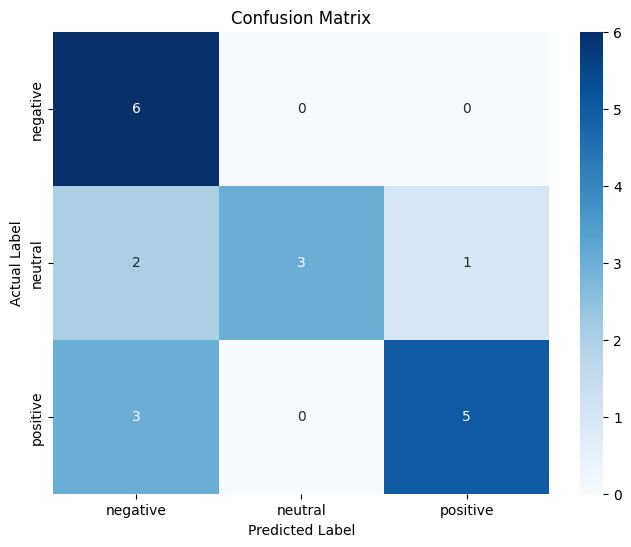

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Evaluate on the test set using test_df instead of president_ds
true_labels = []
predicted_labels = []

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Iterate over each row in test_df
for _, tweet_data in test_df.iterrows():
    tweet = tweet_data["text"]
    true_label = tweet_data["label"]

    # Tokenize and move inputs to the correct device
    inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()

    # Append to the respective lists
    true_labels.append(true_label)
    predicted_labels.append(predicted_class_id)

    # Print the tweet with the predicted and actual sentiments
    print(f"Tweet: {tweet}")
    print(f"Predicted Sentiment: {predicted_class_id}")
    print(f"Actual Sentiment: {true_label}")
    print("-" * 80)

# (Optional) Evaluate the results
print("Evaluation Results:")
print(f"Accuracy: {accuracy_score(true_labels, predicted_labels)}")
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.config.id2label.values(), yticklabels=model.config.id2label.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()
